In [1]:
from os import path
import sys
if '/mnt/home/apricewhelan/projects/stellarstreams/' not in sys.path:
    sys.path.append('/mnt/home/apricewhelan/projects/stellarstreams/')

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits, ascii
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.optimize import minimize

import emcee
from pyia import GaiaData
import schwimmbad

import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics import mockstream
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.mpl_style import center_emph

from stellarstreams.modeling.trackfit import MockStreamModel

In [2]:
galcen_frame = coord.Galactocentric(galcen_distance=8.1*u.kpc)

## Prepare data:

In [3]:
tbl = Table.read('../output/rrl_bhb_bs_rgb_master.fits')

In [4]:
g = GaiaData(tbl)

In [5]:
rv = tbl['rv'].copy()
rv[~np.isfinite(rv)] = 0.

c = coord.SkyCoord(ra=tbl['ra']*u.deg, 
                   dec=tbl['dec']*u.deg,
                   distance=coord.Distance(distmod=tbl['DM']),
                   pm_ra_cosdec=tbl['pmra']*u.mas/u.yr,
                   pm_dec=tbl['pmdec']*u.mas/u.yr,
                   radial_velocity=rv*u.km/u.s)
c_gd1 = c.transform_to(gc.GD1)

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):


In [6]:
cov_gd1 = gc.transform_pm_cov(c, g.get_cov()[:, 3:5, 3:5], gc.GD1)

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in

In [7]:
dist = coord.Distance(distmod=np.random.normal(tbl['DM'], tbl['DM_error'], 
                                               size=(10000, len(tbl))))

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):


In [8]:
data = Table()

data['phi1'] = c_gd1.phi1.wrap_at(180*u.deg)
data['phi1_ivar'] = 1 / (1*u.mas).to(u.deg)**2

data['phi2'] = c_gd1.phi2
data['phi2_ivar'] = 1 / (1*u.mas).to(u.deg)**2

data['distance'] = np.nanmean(dist, axis=0)
data['distance_ivar'] = 1 / np.nanstd(dist.view(u.Quantity), axis=0)**2
data['distance_ivar'][~np.isfinite(data['distance_ivar'])] = 0.

data['pm_phi1_cosphi2'] = c_gd1.pm_phi1_cosphi2
data['pm_phi1_cosphi2_ivar'] = 1 / (cov_gd1[:,0,0]*c_gd1.pm_phi1_cosphi2.unit**2)

data['pm_phi2'] = c_gd1.pm_phi2
data['pm_phi2_ivar'] = 1 / (cov_gd1[:,1,1]*c_gd1.pm_phi2.unit**2)

data['radial_velocity'] = tbl['rv'] * u.km/u.s
data['radial_velocity'][np.isnan(data['radial_velocity'])] = 0.
data['radial_velocity_ivar'] = 1 / (tbl['rv_error'] * u.km/u.s)**2

data = data.filled(fill_value=0)

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in

---

In [9]:
_stream = np.load('../output/stream_model_-20.0.npy')
stream = gd.PhaseSpacePosition(pos=_stream[:, :3].T*u.kpc,
                               vel=_stream[:, 3:].T*u.km/u.s)

In [10]:
phi1_0 = -20*u.deg
w0_p0 = {'phi2': 3.53709061e-02,  
         'distance': 8.897, 
         'pm_phi1_cosphi2': -10, 
         'pm_phi2': -2.27160328, 
         'radial_velocity': -1.38114555e+02}

# phi1_0 = -31.55*u.deg
# p0 = (0.26548956,  7.84480046, -12.82291498, -2.98120049, -70.18707527)

In [11]:
# idx = np.abs(orbit_c.phi1.wrap_at(180*u.deg) - phi1_0).argmin()
# orbit_c[idx]

In [21]:
# pot_init = gp.LogarithmicPotential(v_c=300*u.km/u.s, r_h=15, q1=1, q2=1, q3=0.95, 
#                                    units=galactic)

# (pot_init.circular_velocity([15,0,0.]*u.kpc),
#  gp.MilkyWayPotential().circular_velocity([15,0,0.]*u.kpc))
pot_init = gp.MilkyWayPotential()

In [22]:
model = MockStreamModel(data, stream_frame=gc.GD1(),
                        potential=pot_init, 
                        integrate_kw=dict(dt=-1*u.Myr, n_steps=3000), 
                        mockstream_kw=dict(prog_mass=5e4*u.Msun, release_every=2),
                        phi1_0=phi1_0, frozen={'potential': True},
                        galcen_frame=galcen_frame, 
                        phi1_lim=[-100, 20]*u.deg, phi1_binsize=2*u.deg)

In [23]:
w0 = model.get_w0(**w0_p0)
H = model.get_hamiltonian()
orbit = model.get_orbit(H, w0)
stream = model.get_mockstream(H, orbit[::-1])

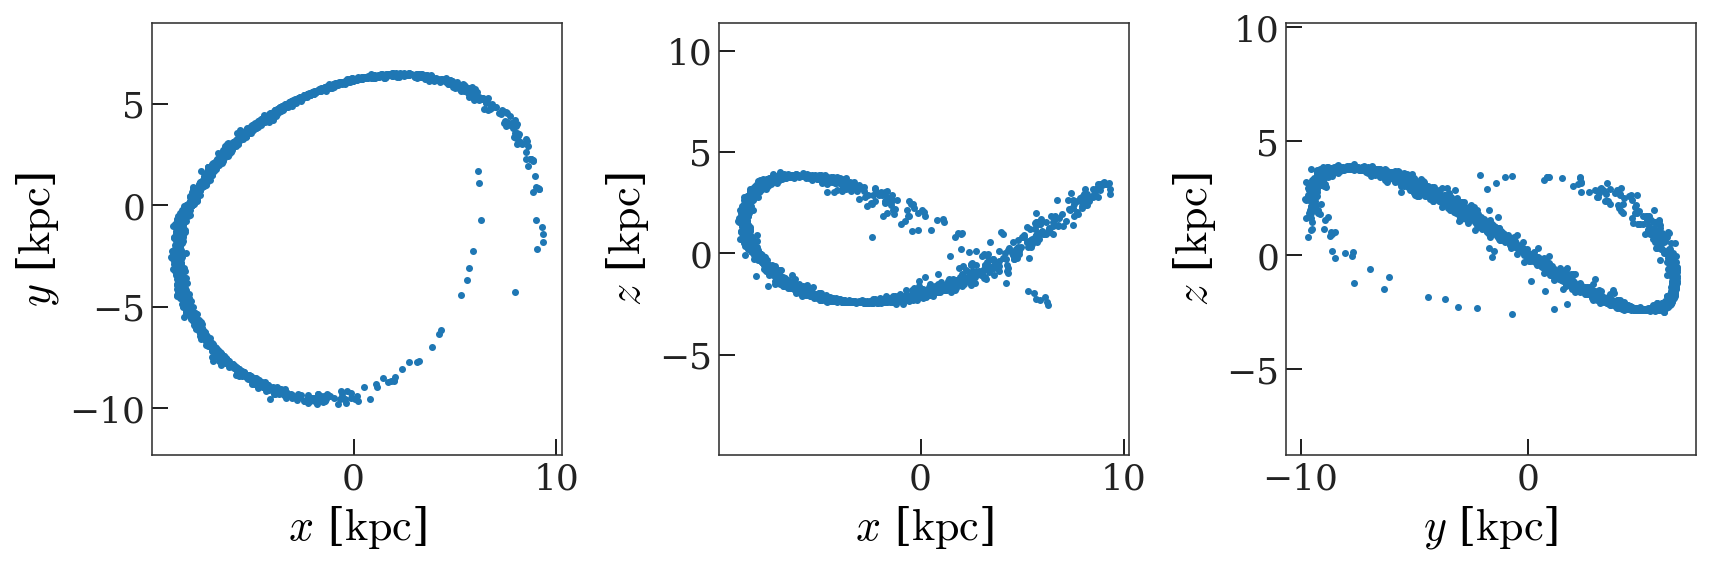

In [24]:
_ = stream.plot()

In [25]:
model.ln_prior({'w0': w0_p0})

-8.288757120891297

In [26]:
%%time
model.ln_likelihood({'w0': w0_p0, 'potential': dict()})

CPU times: user 3.62 s, sys: 14.6 ms, total: 3.63 s
Wall time: 3.63 s


/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/mnt/home/apricewhelan/projects/stellarstreams/stellarstreams/modeling/stats.py:8: RuntimeWarning: divide by zero encountered in log
  return -0.5 * (x-mu)**2 * ivar - 0.5*np.log(2*np.pi) + 0.5*np.log(ivar)


-4.750912022623202e+16

In [205]:
res = minimize(lambda *x: -model.ln_likelihood(*x), 
               x0=p0, 
               bounds=[(-2, 2), (5, 12), (-20, 0), 
                       (-10, 10), (-200, 200), (25, 28), (0.8, 1.2)])

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


---

In [21]:
nwalkers = 64
ndim = len(p0)
p0s = emcee.utils.sample_ball(p0, [1e-3]*ndim, size=nwalkers)

In [28]:
def _worker(pp):
    assert np.isfinite(model(pp))

with schwimmbad.MultiPool() as pool:
    for _ in pool.map(_worker, p0s):
        pass

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

In [34]:
with schwimmbad.MultiPool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim=ndim, 
                                    log_prob_fn=model,
                                    pool=pool)
    sampler.run_mcmc(p0s, 512)

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` in

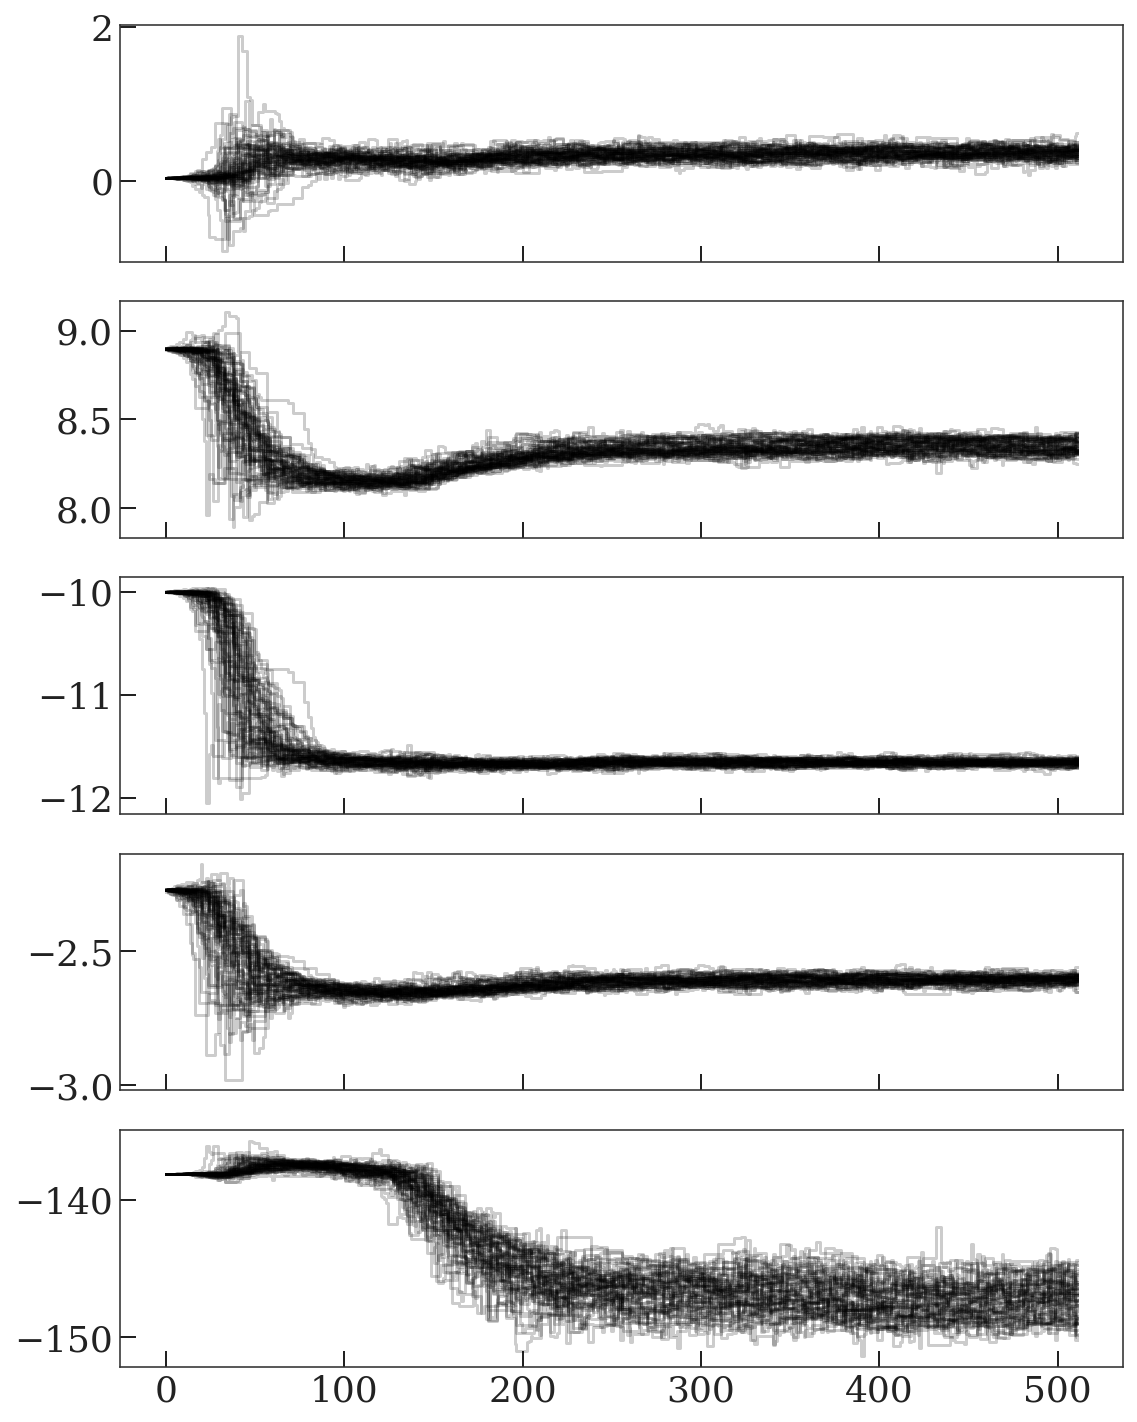

In [37]:
fig, axes = plt.subplots(sampler.ndim, 1, figsize=(8, 2*sampler.ndim),
                         sharex=True)
for k in range(sampler.ndim):
    for walker in sampler.chain[..., k]:
        axes[k].plot(walker, marker='', drawstyle='steps-mid', 
                     color='k', alpha=0.2)
        
fig.tight_layout()

In [43]:
# with open('fit-stream-track-chain.pkl', 'wb') as f:
#     pickle.dump(sampler.chain, f)

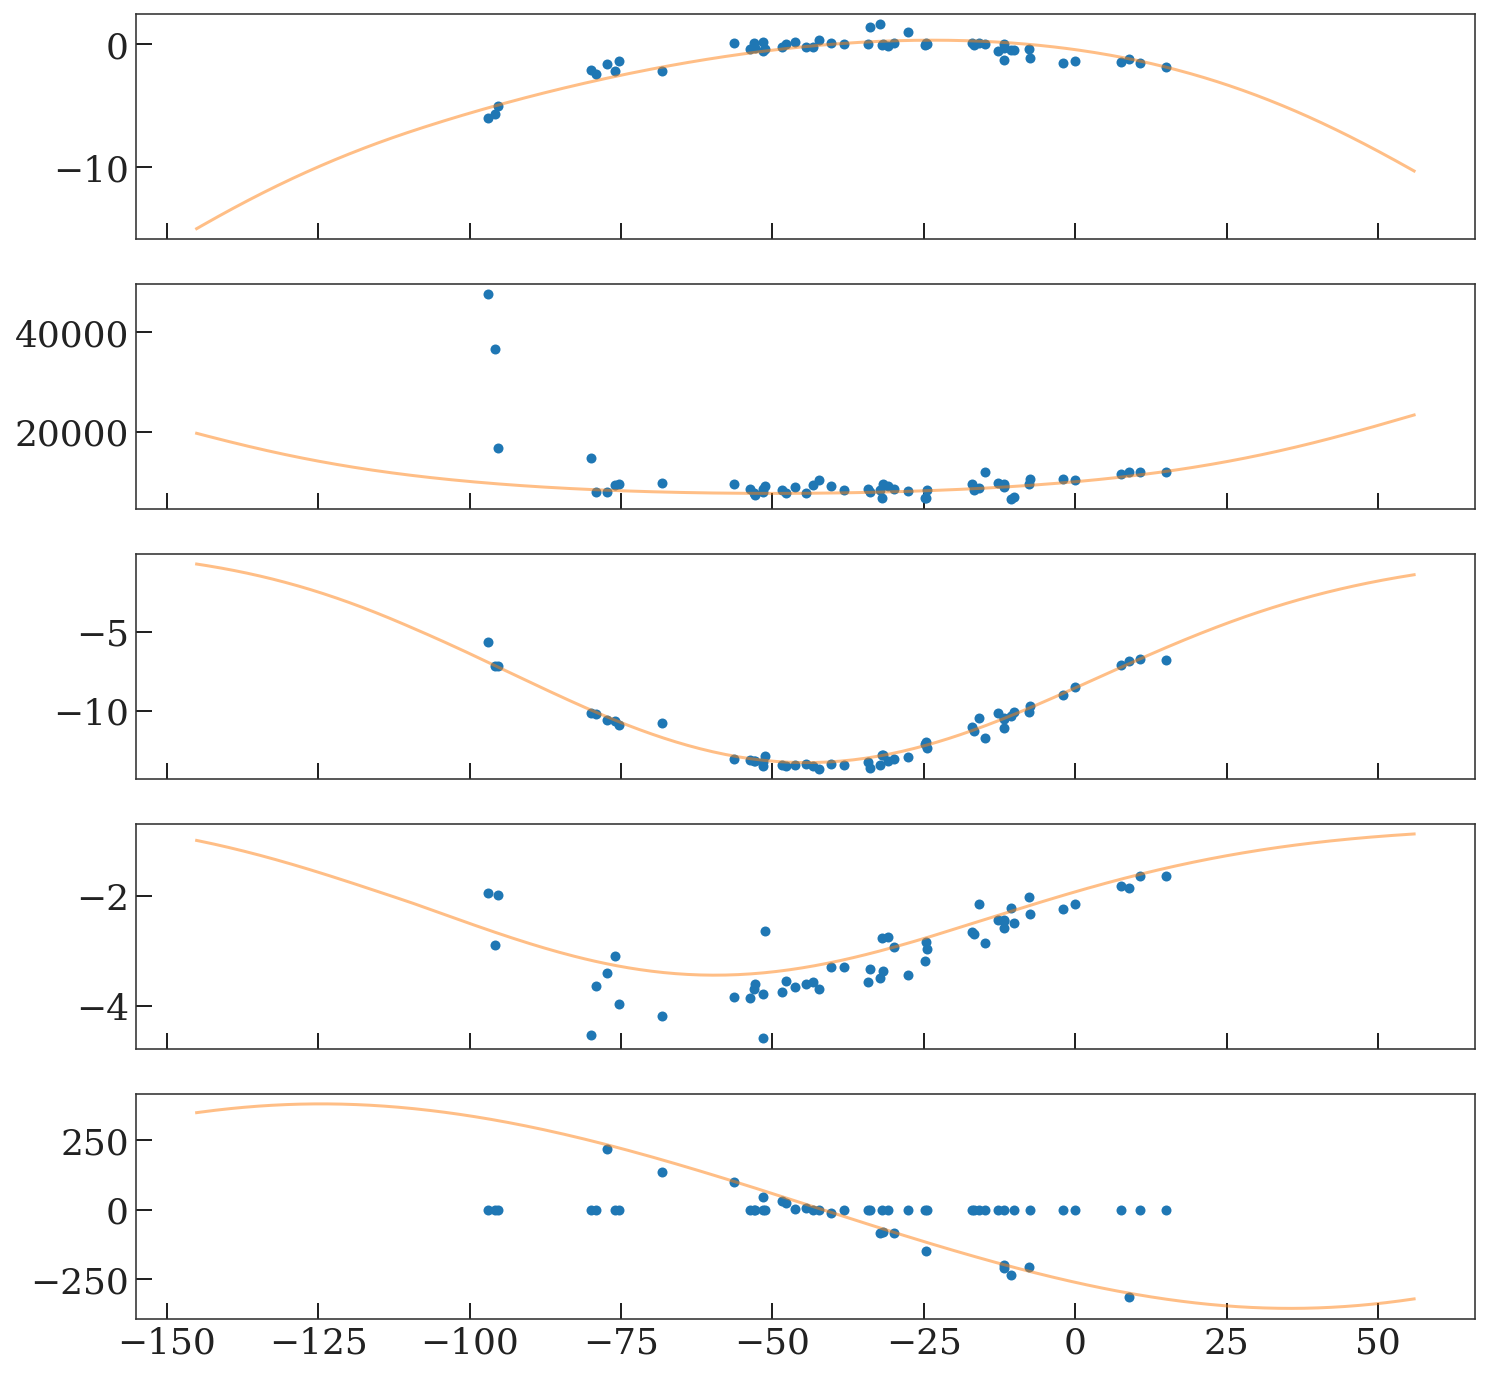

In [141]:
comp_names = (list(orbit_c.get_representation_component_names()) + 
              list(orbit_c.get_representation_component_names('s')))

fig, axes = plt.subplots(5, 1, figsize=(12, 12,), 
                         sharex=True)

for i, attr in enumerate(comp_names[1:]):
    ax = axes[i]
    ax.plot(c_gd1.phi1.wrap_at(180*u.deg).degree,
            getattr(c_gd1, attr).value,
            marker='o', ls='none')
    
# for pp in sampler.chain[:, -1][:16]:
for pp in [res.x]:
    w0 = model.get_w0(pp)
    _orbit = ham.integrate_orbit(w0, dt=-0.5*u.Myr, n_steps=200)
    orbit = ham.integrate_orbit(_orbit[-1], dt=0.5*u.Myr, n_steps=400)
    orbit_c = orbit.to_coord_frame(gc.GD1, galactocentric_frame=model.galcen_frame)

    for i, attr in enumerate(comp_names[1:]):
        ax = axes[i]
        ax.plot(orbit_c.phi1.wrap_at(180*u.deg).degree,
                getattr(orbit_c, attr).to_value(getattr(c_gd1, attr).unit),
                marker='', ls='-', alpha=0.5, color='tab:orange')

In [133]:
# model2 = MockStreamModel(data, stream_frame=gc.GD1(),
#                         potential=gp.MilkyWayPotential(), 
#                         dt=-0.5*u.Myr, n_steps=6000, phi1_0=-20*u.deg,
#                         galcen_frame=galcen_frame, release_every=2,
#                         phi1_lim=[-100, 20]*u.deg, phi1_binsize=2*u.deg)

In [142]:
%%time
pp = res.x
stream = model.get_mockstream(pp)

CPU times: user 2.9 s, sys: 1.72 ms, total: 2.9 s
Wall time: 2.9 s


(-100, 20)

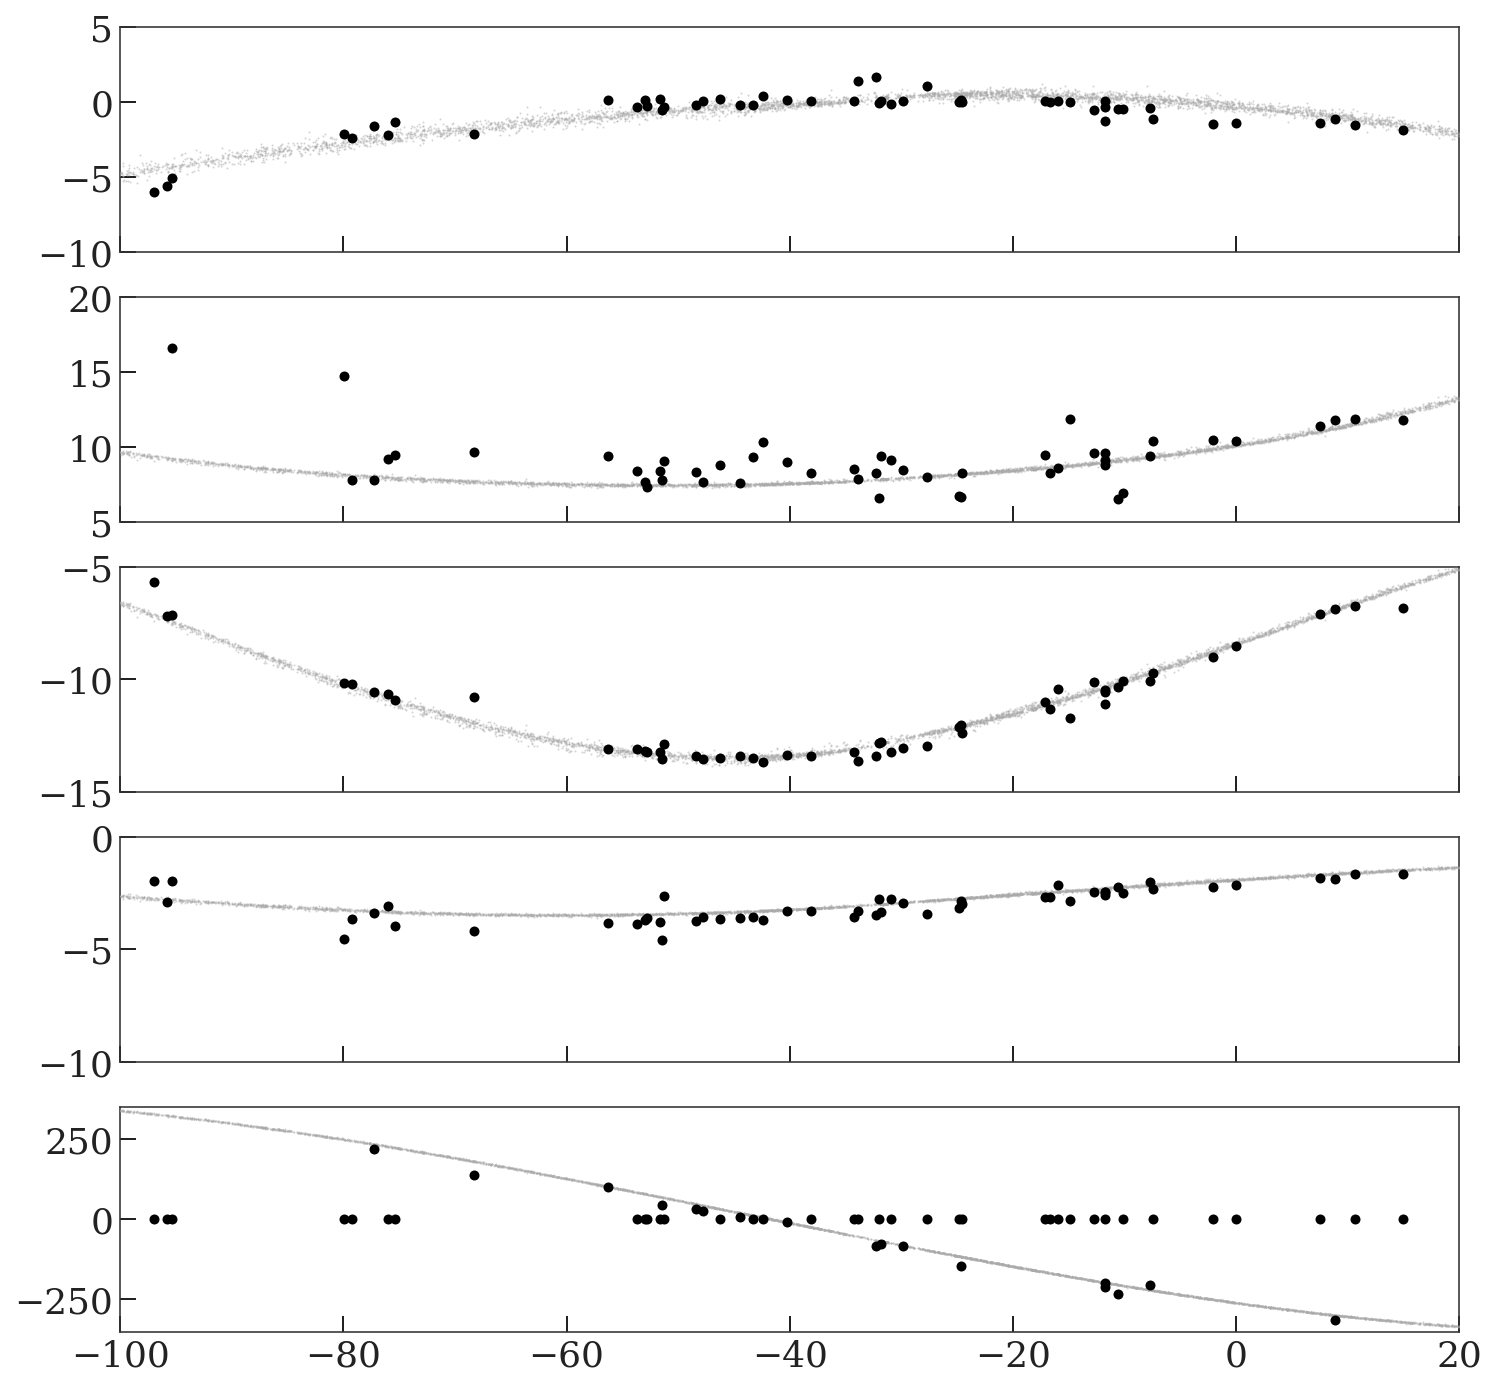

In [143]:
fig, axes = plt.subplots(5, 1, figsize=(12, 12,), 
                         sharex=True)

_unit = {'phi2': u.deg, 'distance': u.kpc, 
         'pm_phi1_cosphi2': u.mas/u.yr,
         'pm_phi2': u.mas/u.yr,
         'radial_velocity': u.km/u.s}
_lim = {'phi2': (-10, 5), 
        'distance': (5, 20), 
        'pm_phi1_cosphi2': (-15, -5),
        'pm_phi2': (-10, 0),
        'radial_velocity': (-350, 350)}

for i, attr in enumerate(comp_names[1:]):
    ax = axes[i]
    ax.plot(c_gd1.phi1.wrap_at(180*u.deg).degree,
            getattr(c_gd1, attr).to_value(_unit[attr]),
            marker='o', ls='none', color='k', zorder=100)
    
stream_c = stream.to_coord_frame(gc.GD1, 
                                 galactocentric_frame=model.galcen_frame)

for i, attr in enumerate(comp_names[1:]):
    ax = axes[i]
    ax.plot(stream_c.phi1.wrap_at(180*u.deg).degree,
            getattr(stream_c, attr).to_value(_unit[attr]),
            marker='o', ls='none', ms=1., alpha=0.5, 
            color='#aaaaaa', zorder=10)
    
    ax.set_ylim(_lim[attr])
    
ax.set_xlim(-100, 20)